In [1]:
#RUN ONLY ONCE
import cv2
import numpy as np
from matplotlib import pyplot as plt
import time
import math

In [2]:
#RUN ONLY ONCE
cap = cv2.VideoCapture(1)
    
if not cap.isOpened():
    print("Could not access webcam")

In [3]:

def get_picture_optimized(cap):
    """
    Capture a frame from the webcam, return it as a BGR numpy array.
    """
    
    w = 1920
    h = 1080

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, w)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, h)
    cap.set(cv2.CAP_PROP_EXPOSURE, -7)
    #cap.set(cv2.CAP_PROP_SATURATION, 50)
    #cap.set(cv2.CAP_PROP_BRIGHTNESS, 0.4)
    #cap.set(cv2.CAP_PROP_CONTRAST, 0.7)
    #cap.set(cv2.CAP_PROP_SATURATION, 0.2)  # reduce saturation to reduce glare
    #cap.set(cv2.CAP_PROP_EXPOSURE, -4)     # lower exposure to avoid reflections
    time.sleep(0.1)  # let the camera apply settings
    
    ret, frame = cap.read()
    #cap.release()
    
    if ret:
        return frame
    else:
        print("Failed to capture frame")
        return None

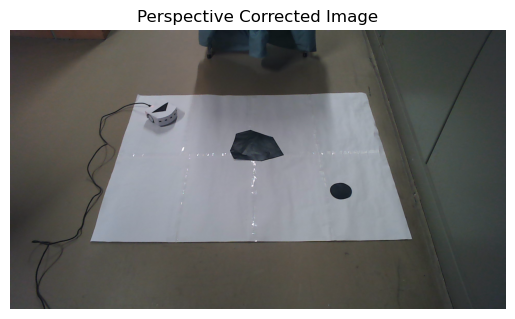

In [22]:
img = get_picture_optimized(cap)
plt.figure()
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title("Perspective Corrected Image")
plt.axis('off')
plt.show()

In [4]:
def length_real_to_pixel(length_cm, env_size_cm, map_size):
    
    L, W = env_size_cm
    height, width = map_size
    
    # scale factors
    scale_x = width / L
    scale_y = height / W
    
    # average scale for uniform scaling
    scale = (scale_x + scale_y) / 2
    
    return length_cm * scale

In [11]:
#================HYPERPARAMETESRS======================

#SiZE OF THE ENVIRONEMENT (cm)
L = 113.5
W = 81.3
Ratio = L/W

#SiZE IN PIXEL OF THE CORRECTED MAP
Y_res = 480
SIZE = [Y_res, int(Y_res*Ratio)]

#SIZE OF THE TRIANGLE (cm)
L_T = 10
H_T = 3.5
L_T_p = length_real_to_pixel(L_T,[L,W], SIZE)
H_T_p = length_real_to_pixel(H_T,[L,W], SIZE)

#SIZE OF THE GOAL (cm)
R_G = 8.4/2

R_G_p = length_real_to_pixel(R_G,[L,W], SIZE)

# AREA RATIO
RATIO_T = (L_T*H_T/2) / (L*W) 

#FILTERING PARAMETERS FOR THE ORIGINAL IMAGE
B1_O = 5
B2_O = 50
B3_O = 50
C1_O = 0.5
C2_O = 1.5
M1_O = 8
CL1_O = 2.0
M_O = 5
D_O = 5

#FILTERING PARAMETERS FOR THE CORRECTED IMAGE
B1_C = 10
B2_C = 80
B3_C = 80
C1_C = 0.4
C2_C = 1.6
M1_C = 5
CL1_C = 4.0
M_C = 5
D_C = 5

#FILTERING PARAMETERS FOR ROBOT DETECTION
B1_T = 5
B2_T = 80
B3_T = 80
C1_T = 0.4
C2_T = 1.6
M1_T = 5
CL1_T = 2
M_T = 2
D_T = 2


#PARAMETERS TO DETECT THE ENV
#Min_area_env = 1920*1080*0.01   #Min area in pixel of the env
Min_area_env = 1000
Env_approx = 0.1

#PARAMETERS TO DETECT THE OBSTACLES
Min_area_obs = SIZE[0]*SIZE[1]*0.005   #Min area in pixel of the env
Max_area_obs = SIZE[0]*SIZE[1]*0.5   #Max area in pixel of the env
Obs_approx = 0.01

#PARAMETERS TO DETECT GOAL
Min_area_goal = np.pi * R_G_p * R_G_p *0.8
Max_area_goal = np.pi * R_G_p * R_G_p * 1.8

#PARAMETERS TO DETECT THE ROBOT
Min_area_rob = (L_T_p*H_T_p /2) * 0.2   #Min area in pixel of the env
Max_area_rob =  (L_T_p*H_T_p /2) * 1.8
Rob_approx = 0.08

#ROBOT CARACTERISTICS
R_ROBOT = 6
R_ROBOT_p = length_real_to_pixel(R_ROBOT,[L,W], SIZE)


#SYMBOLS FOR THE MAP
FREE_SPACE = 0
OCCUPIED_SPACE = -1
GOAL = -3

DEBUG = True
#========================================================

In [7]:
#=====GEOMETRICAL FUNCIONS=====
def orderpoints(pts) :
    """
    INPUT : 4 points
    OUTPUT : 4 points ordered
    Order points of a square counterclockwise
    """
    pts = pts[np.argsort(pts[:, 1]), :]  # sort by y
    
    # Step 2: top two points
    top = pts[:2]
    # bottom two points
    bottom = pts[2:]
    
    # Step 3: sort top-left and top-right by x
    if top[0, 0] < top[1, 0]:
        tl, tr = top[0], top[1]
    else:
        tl, tr = top[1], top[0]
        
    # Step 4: sort bottom-left and bottom-right by x
    if bottom[0, 0] < bottom[1, 0]:
        bl, br = bottom[0], bottom[1]
    else:
        bl, br = bottom[1], bottom[0]
    
    return np.array([tl, tr, br, bl], dtype="float32")

def find_square(contour, approx, area) :
    """
    INPUT : IMAGE, percentage of approximation, minimum area
    OUTPUT : if a square is detected, square countour
    """
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)
    
    if len(cnt) == 4 and cv2.contourArea(cnt) > area and cv2.isContourConvex(cnt):
        find = True
        return find, cnt.reshape(-1,2)
    else : 
        find = False
        return find, None
        
def find_shape(contour, approx, area_min, area_max = 100000000000) :
    
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)
    
    if cv2.contourArea(cnt) > area_min and cv2.contourArea(cnt) < area_max  :
        print("True")
        find = True
        return find, cnt.reshape(-1,2)
    else : 
        find = False
        return find, None
    
def find_triangle(contour, approx, area_min, area_max, image = None) :
    cnt_len = cv2.arcLength(contour, True)
    cnt = cv2.approxPolyDP(contour, approx*cnt_len, True)

    if DEBUG :
        image_plot = image.copy()
        cv2.drawContours(image_plot, [cnt], -1, (255, 0, 0), 2)

    if DEBUG :
        plt.figure()
        plt.imshow(cv2.cvtColor(image_plot, cv2.COLOR_BGR2RGB))
        plt.title("Potential triangle")
        plt.axis('off')
        plt.show()
    
        
    elem = []
    if len(cnt) == 3 and cv2.contourArea(cnt) > area_min and cv2.contourArea(cnt) < area_max:
        cnt = cnt.reshape(-1, 2)
        elem = cnt
        find = True
        return find, elem
    else : 
        find = False
        return find, elem
        return find, elem

def find_circle(contour, min_area, max_area) :
    (x, y), radius = cv2.minEnclosingCircle(contour)

    area_contour = cv2.contourArea(contour)
    area_circle = np.pi * radius * radius
    find = False
    circularity = area_contour / area_circle
    circle = []
    
    if 0.5 < circularity < 1.9 and (area_circle > min_area and area_circle < max_area):
        
        center = (int(x), int(y))
        radius = int(radius)
        circle = [center,radius]
        find = True
        return find, circle, circularity
    
    return find, circle, circularity

        
def get_inter_shape(shapes):
    occupancy = np.zeros((SIZE[0], SIZE[1]))
    
    for shape in shapes:
        cv2.drawContours(occupancy, [shape], -1, 1, cv2.FILLED)
    return occupancy

def altitude_line(TOP, B, C):
    """
    Returns the parametric line of the altitude from base B-C to the TOP vertex.
    """
    Tx, Ty = TOP
    Bx, By = B
    Cx, Cy = C

    # base vector
    ux = Cx - Bx
    uy = Cy - By

    # vector from B to TOP
    wx = Tx - Bx
    wy = Ty - By

    # projection scalar to get foot of altitude
    u_dot_u = ux*ux + uy*uy
    t = (wx*ux + wy*uy) / u_dot_u

    # foot of altitude (on base)
    Px = Bx + t*ux
    Py = By + t*uy

    # direction vector from base to TOP
    vx = Tx - Px
    vy = Ty - Py

    return (Px, Py), (vx, vy)

def order_triangle(P1,P2,P3) :
    dist_A = math.dist(P1, P2)
    dist_B = math.dist(P2, P3)
    dist_C = math.dist(P3, P1)
    
    diff_A_B = abs(dist_A-dist_B)
    diff_B_C = abs(dist_B-dist_C)
    diff_C_A = abs(dist_C-dist_A)
    
    if diff_A_B < diff_B_C and diff_A_B < diff_C_A :
        TOP = P2
        LEFT = P1
        RIGHT = P3
        confidence = diff_A_B
    elif diff_B_C < diff_A_B and diff_B_C < diff_C_A :
        TOP = P3
        LEFT = P2
        RIGHT = P1
        confidence = diff_B_C
    elif diff_C_A < diff_A_B and diff_C_A < diff_B_C :
        TOP = P1
        LEFT = P3
        RIGHT = P2
        confidence = diff_C_A
    else :
        print("no summit found, adjust threshold")

    ordered = [TOP,LEFT, RIGHT]
    return ordered, confidence
    
def get_occupancy(squares):
    occupancy = np.zeros((SIZE[0], SIZE[1]))
    for shape in squares:
        pts = orderpoints(np.array(shape)).astype(np.int32)
        cv2.fillConvexPoly(occupancy, pts, OCCUPIED_SPACE)
    return occupancy

def square_overlaps_circle(square, cx, cy, r):
    # 1. Check if a vertex of the square is inside the circle
    for (x, y) in square:
        if (x - cx)**2 + (y - cy)**2 <= r*r:
            return True

    # 2. Check if circle center is inside the square (rare but possible)
    if cv2.pointPolygonTest(square.astype(np.float32), (cx, cy), False) >= 0:
        return True

    return False


def dist_point_to_segment(px, py, ax, ay, bx, by):
    """Distance from point P to segment AB."""
    A = np.array([ax, ay], dtype=float)
    B = np.array([bx, by], dtype=float)
    P = np.array([px, py], dtype=float)

    AB = B - A
    AP = P - A

    t = np.dot(AP, AB) / np.dot(AB, AB)
    t = np.clip(t, 0, 1)  # projection inside segment

    closest = A + t * AB
    return np.linalg.norm(P - closest)

def dist_point_to_polygon(px, py, polygon):
    """Polygon = list/array of (x,y)."""
    min_dist = float('inf')
    n = len(polygon)

    for i in range(n):
        x1, y1 = polygon[i]
        x2, y2 = polygon[(i+1) % n]
        d = dist_point_to_segment(px, py, x1, y1, x2, y2)
        if d < min_dist:
            min_dist = d

    return min_dist
    
def contour_fixing(image) :
    h, w = image.shape[:2]

    # border width
    b = 10

    image[:b, :] = (255, 255, 255)

    image[h-b:h, :] = (255, 255, 255)

    image[:, :b] = (255, 255, 255)

    image[:, w-b:w] = (255, 255, 255)
    return image


In [8]:
#=====FILTERING FUNCTIONS=====
def filter_image(image, b1, b2, b3, c1, c2, m1, cl1, m, d, env = False, dil = True) :
    """
    INPUT : IMAGE AND FILTER PARAMETERS
    OUTPUT : IMAGE FILTERED
    Apply successive filters to a given image : 
    1. Convert to GreyScale
    2. Bilatera filter
    3. Canny edge filter
    4. Morphological filter
    """
    if env :
        image= contour_fixing(image)
        
    # Grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Bilateral filter
    filtered_img = cv2.bilateralFilter(gray, b1, b2, b3)

    if DEBUG :
        plt.figure()
        plt.imshow(filtered_img, cmap='gray')
        plt.title("Bilateral image")
        plt.axis('off')
        plt.show()
    
    # Canny edges
    median_val = np.median(gray)
    lower = int(max(0, c1 * median_val))
    upper = int(min(255, c2 * median_val))
    canny_img = cv2.Canny(filtered_img, lower, upper)

    if DEBUG :
        plt.figure()
        plt.imshow(canny_img, cmap='gray')
        plt.title("canny image")
        plt.axis('off')
        plt.show()

    if dil :
        # Morphological filter
        kernel1 = np.ones((m,m), np.uint8)
        kernel2 = np.ones((d,d), np.uint8)
        closed = cv2.morphologyEx(canny_img, cv2.MORPH_CLOSE, kernel1)
        
        closed = cv2.dilate(closed, kernel2, iterations=1)
        closed = cv2.morphologyEx(closed, cv2.MORPH_CLOSE, kernel1)

    
        if DEBUG :
            plt.figure()
            plt.imshow(closed, cmap='gray')
            plt.title("Filtered image")
            plt.axis('off')
            plt.show()
        return closed
        
    else :
        return canny_img


In [9]:
def matrix_perspective(image) :

    filtered_image = filter_image(image, B1_O, B2_O , B3_O, C1_O, C2_O, M1_O, CL1_O, M_O, D_O, False)
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    if DEBUG : image_plot = image.copy()
        
    squares = []
    for cnt in contours:
        find = False
        find, square = find_square(cnt, Env_approx, Min_area_env)
        if find :
            squares.append(square)
            if DEBUG :
                cv2.drawContours(image_plot, [square], -1, (255, 0, 0), 2)

    if DEBUG :
        plt.figure()
        plt.imshow(cv2.cvtColor(image_plot, cv2.COLOR_BGR2RGB))
        plt.title("Detected Quadrilaterals (blue)")
        plt.axis('off')
        plt.show()
        print(squares)
    
    area = 0
    sheet = None
    for square in squares:
        if cv2.contourArea(square) > area :
            sheet = square
            area = cv2.contourArea(square)
        
    
    if sheet is not None:
        sheet_ordered = orderpoints(sheet)
        tl, tr, br, bl = [tuple(pt.astype(int)) for pt in sheet_ordered]
    else : print("ERROR : SHEET is EMPTY")
    
    pts1 = sheet_ordered
    pts2 = np.array([[0, 0], [SIZE[1]-1, 0], [SIZE[1]-1, SIZE[0]-1], [0, SIZE[0]-1]],dtype=np.float32)
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    return matrix

def convert_perspective(image,matrix) : 
    
    transformed_image = cv2.warpPerspective(image,matrix,(SIZE[1],SIZE[0]))
    return transformed_image

def pixel_to_world_mm(pos):
    px, py = pos
    x = 10 * px * (L / SIZE[1])
    y = 10 * py * (W / SIZE[0])
    return x, y

def get_robot(image):
    
    filtered_image = filter_image(image, B1_T, B2_T , B3_T, C1_T, C2_T, M1_T, CL1_T, M_T, D_T, True, True)
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_contours_plot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Contours dessinés")
        plt.show()
     
        image_contours = transformed_image.copy()
    
    triangle =[]
    find_t = False
    confidence = 100
    for cnt in contours:
        find_t, tri= find_triangle(cnt, Rob_approx, Min_area_rob, Max_area_rob, image)
        #print(tri)
        if find_t :
            _, conf = order_triangle(tri[0], tri[1], tri[2])
            if conf < confidence :
                triangle = tri
                confidence = conf
                if DEBUG :
                    cv2.drawContours(image_contours, [triangle], -1, (255, 0, 0), 2)

    pos = []
    angle = 0
    if triangle is not None and len(triangle) != 0:
        if DEBUG :
            cv2.drawContours(image_contours, [triangle], -1, (255, 255, 0), 2)
            plt.figure()
            plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
            plt.title("Detected shapes (blue)")
            plt.axis('off')
            plt.show()
            print(triangle)
            
        tri_ordered,_ = order_triangle(triangle[0], triangle[1], triangle[2])
        alt = altitude_line(tri_ordered[0], tri_ordered[1], tri_ordered[2] )
        pos = alt[0]
        angle = np.atan2(alt[1][1],alt[1][0])
        print("ROBOT FOUND")
        Rob = True
    else :
        print("NO ROBOT FOUND")
        Rob = False
    #pos = pixel_to_world_mm(pos)
    return pos, angle, Rob


def get_map(image) :

    filtered_image = filter_image(image, B1_C, B2_C , B3_C, C1_C, C2_C, M1_C, CL1_C, M_C, D_C, True)
   
    
    contours, hierarchy = cv2.findContours(filtered_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    if DEBUG :
        plt.figure()
        image_contours_plot = image.copy()
        cv2.drawContours(image_contours_plot, contours, -1, (0, 255, 0), 2)
        plt.imshow(cv2.cvtColor(image_contours_plot, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title("Contours dessinés")
        plt.show()  
        image_contours = transformed_image.copy()

    
    robot_pos,_, Rob = get_robot(image)
    
    shapes =[]
    find_s = False
    find_circ = False
    confidence = 100
    for cnt in contours:
        print("Trying to find obstacles")
        find_s, shape= find_shape(cnt, Obs_approx, Min_area_obs, Max_area_obs)
        find_c, circle_pot, confidence_pot = find_circle(cnt, Min_area_goal, Max_area_goal)
        if find_s :
            print(dist_point_to_polygon(robot_pos[0], robot_pos[1], shape))
            if dist_point_to_polygon(robot_pos[0], robot_pos[1], shape) > R_ROBOT_p :
                print("and true")
                shapes.append(shape)
                if DEBUG : cv2.drawContours(image_contours, [shape], -1, (255, 0, 0), 2)
        if find_c:
            if Rob : 
                # compute distance between robot and circle
                cx, cy = circle_pot[0]
                rx, ry = robot_pos
                dist = np.hypot(cx - rx, cy - ry)
                # ignore circle if too close to robot
                if abs(confidence_pot - 1) < confidence and dist > R_ROBOT_p:
                    confidence = abs(confidence_pot - 1)
                    circle = circle_pot
                    find_circ = True
            else :
                if abs(confidence_pot - 1) < confidence :
                    confidence = abs(confidence_pot - 1)
                    circle = circle_pot
                    find_circ = True

    if find_circ:
        cx, cy = circle[0]
        r = circle[1]

        shapes = [
            sh for sh in shapes
            if dist_point_to_polygon(cx, cy, sh) > r
            ]

   
    if DEBUG :
        plt.figure()
        plt.imshow(cv2.cvtColor(image_contours, cv2.COLOR_BGR2RGB))
        plt.title("Detected shapes (blue)")
        plt.axis('off')
        plt.show()
    
    map_ = get_inter_shape(shapes)

    
    if find_circ :
        if DEBUG :
            cv2.circle(image_contours, circle[0], circle[1], (0, 255, 0), -1)
            
        (cx, cy) = circle[0]
        radius = circle[1]
        # Dimensions
        h, w = map_.shape
    
        # Grille de coordonnées
        Y, X = np.ogrid[:h, :w]
    
        # Condition du disque (distance <= rayon)
        dist_mask = (X - cx)**2 + (Y - cy)**2 <= radius**2
    
        # Application
        map_[dist_mask] = GOAL
    
        
        map_[cy,cx] = GOAL
        
    if DEBUG :    
        plt.imshow(map_, cmap='gray')
        plt.axis('off')
        plt.show()

    print("MAP ANALYZED : ")
    if find_circ:
       print("GOAL FOUND")
    else:
        print("NO GOAL DETECTED")
       
    return map_

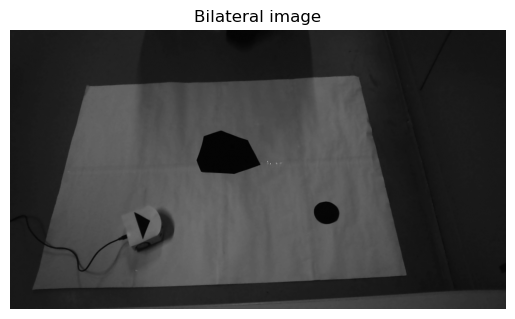

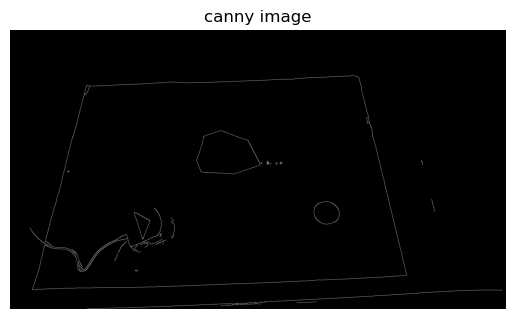

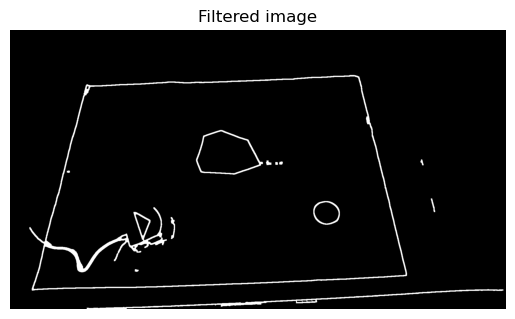

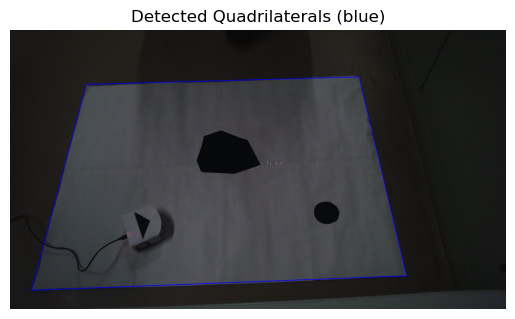

[array([[1352,  181],
       [ 296,  210],
       [  84, 1007],
       [1535,  951]], dtype=int32)]


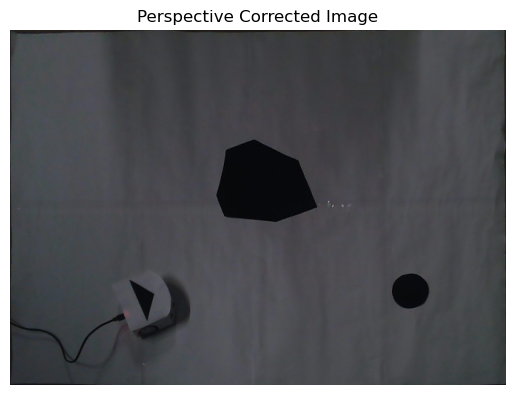

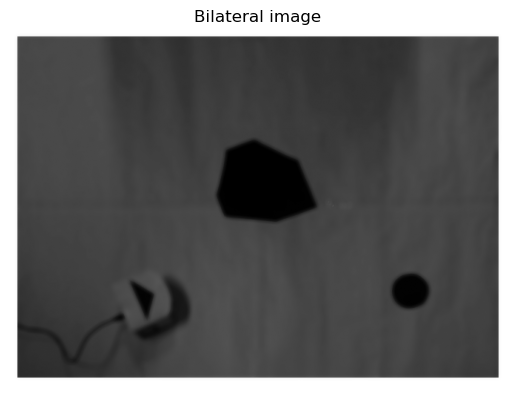

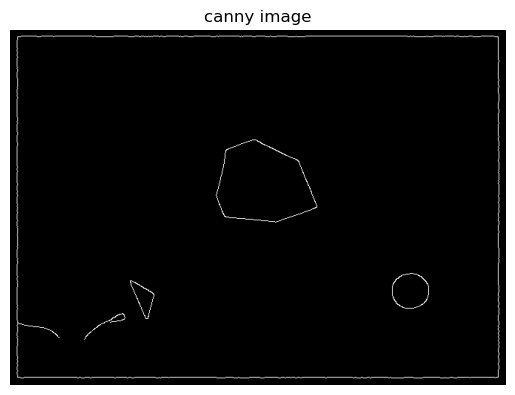

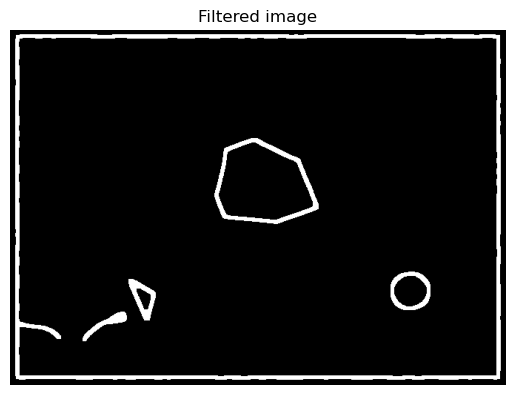

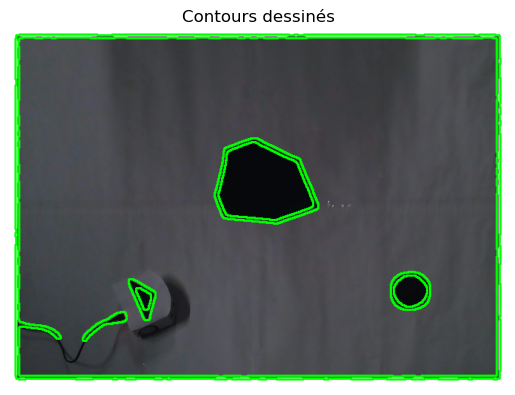

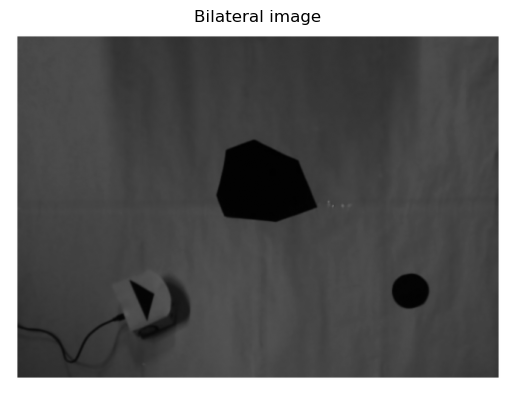

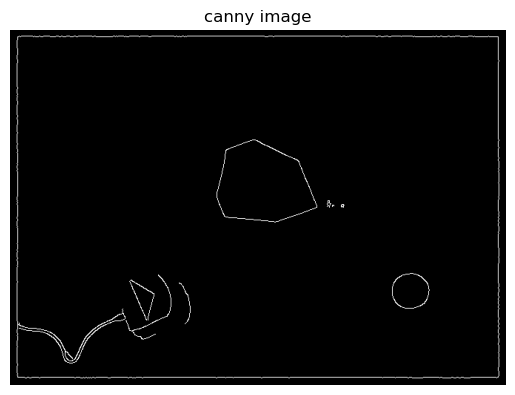

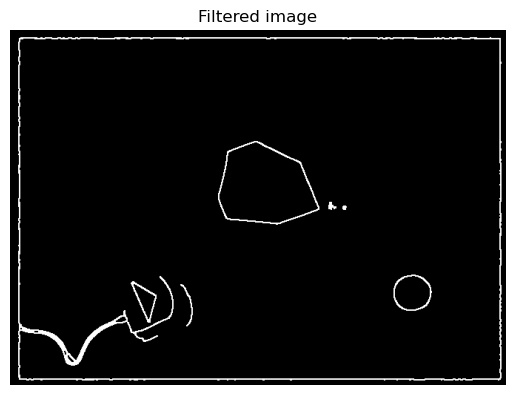

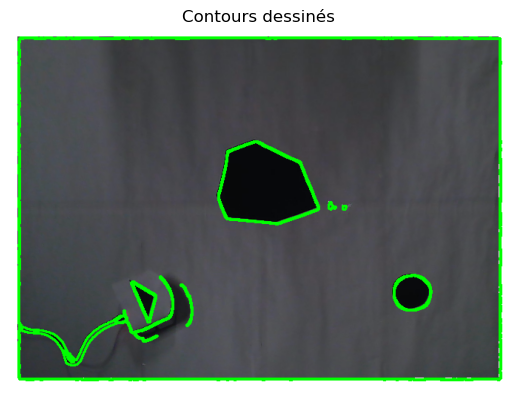

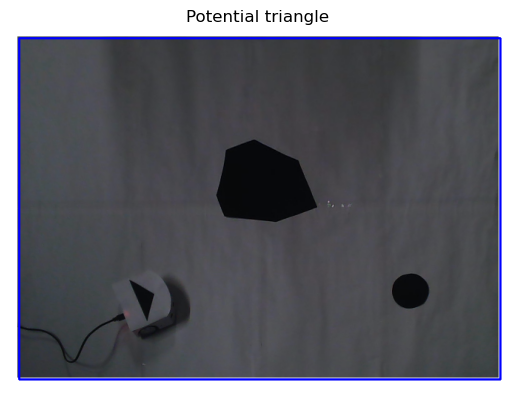

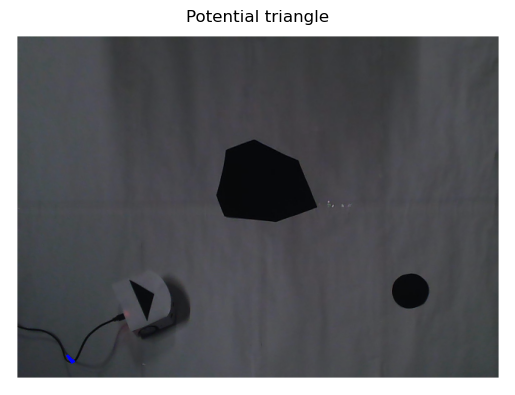

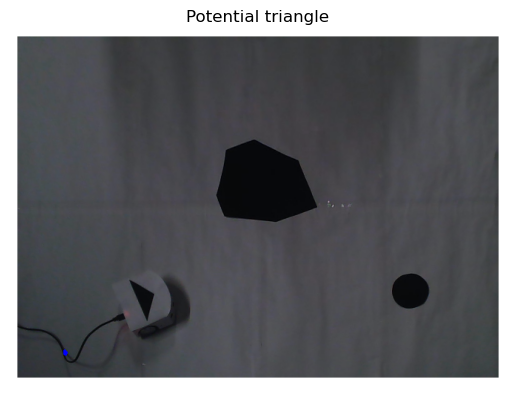

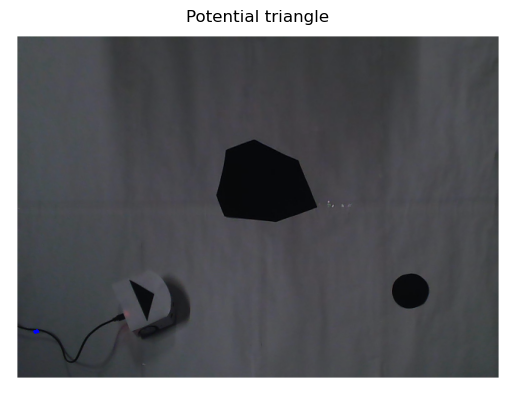

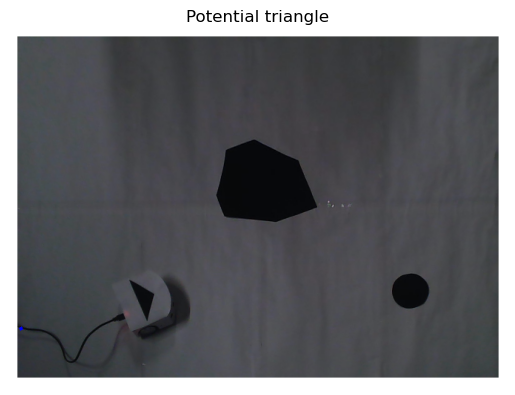

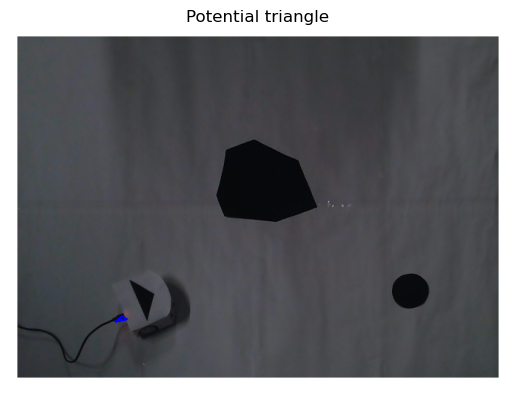

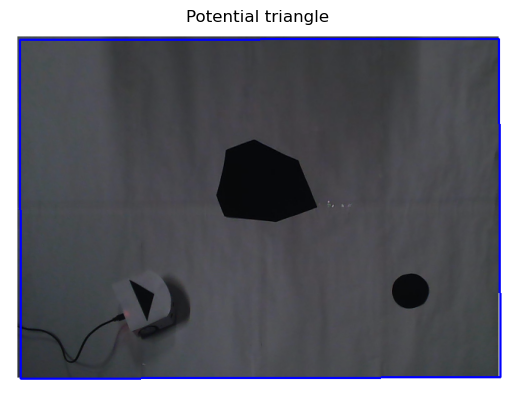

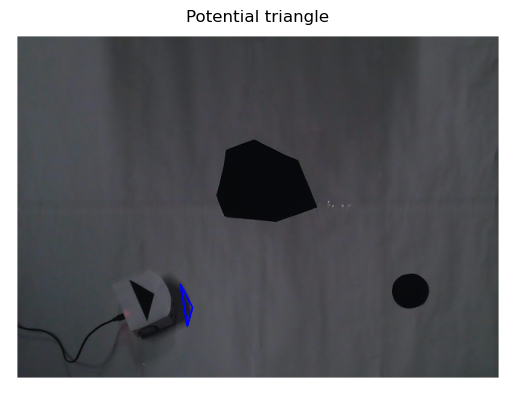

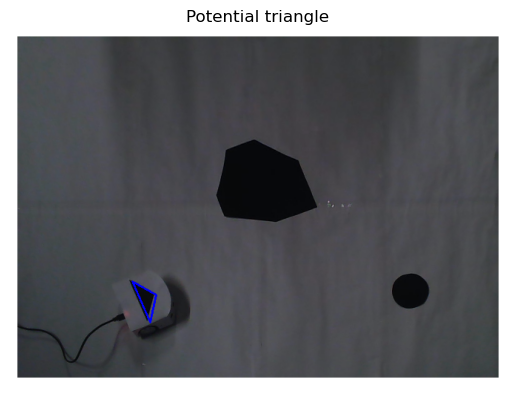

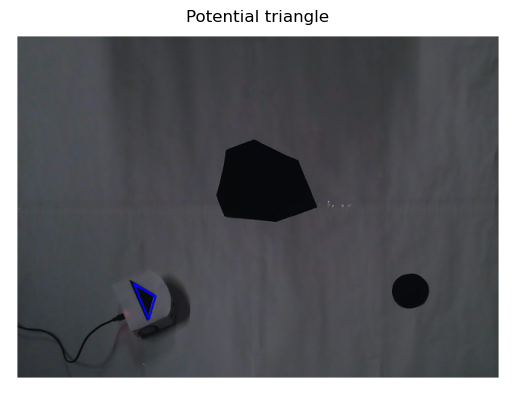

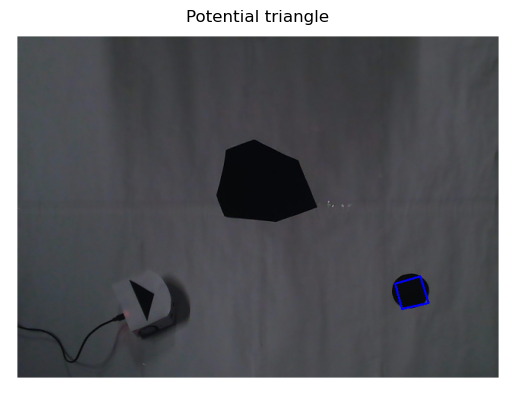

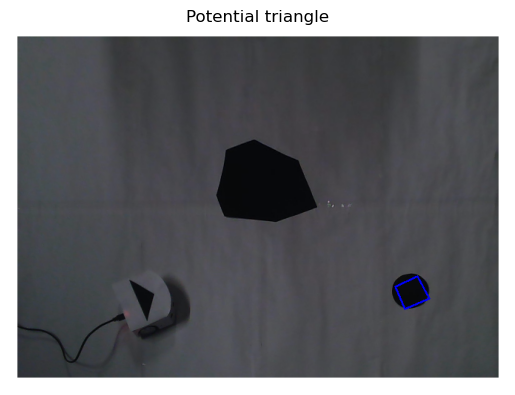

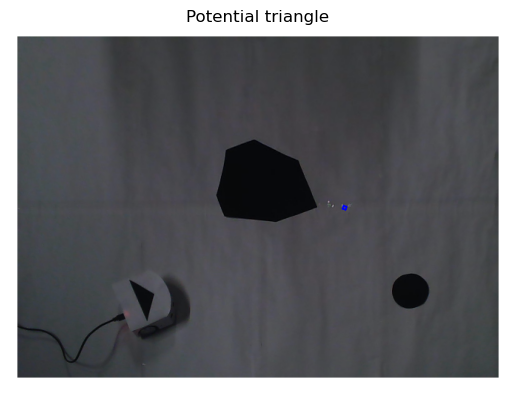

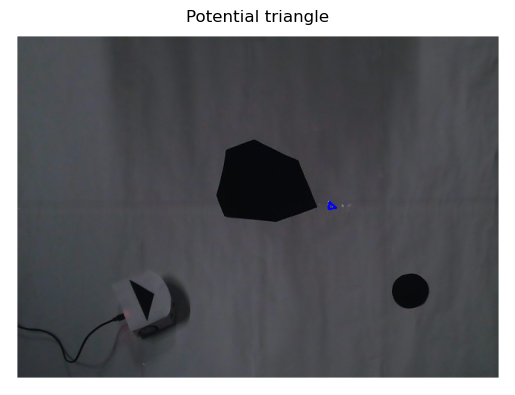

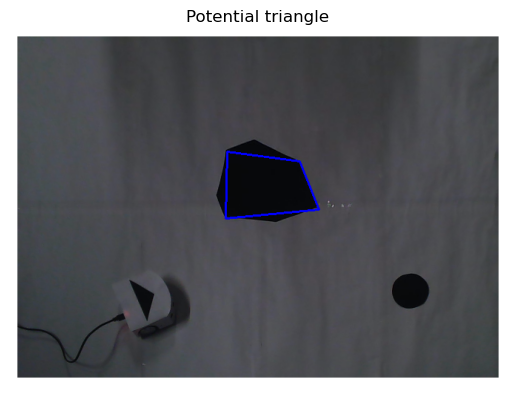

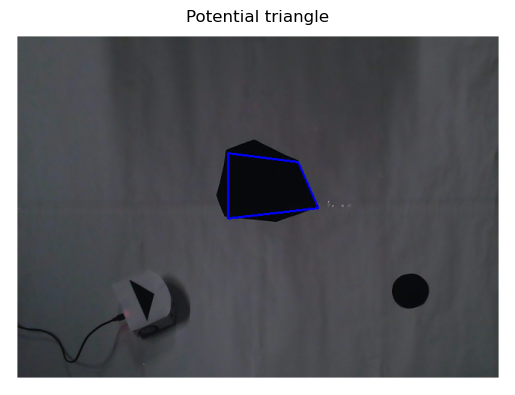

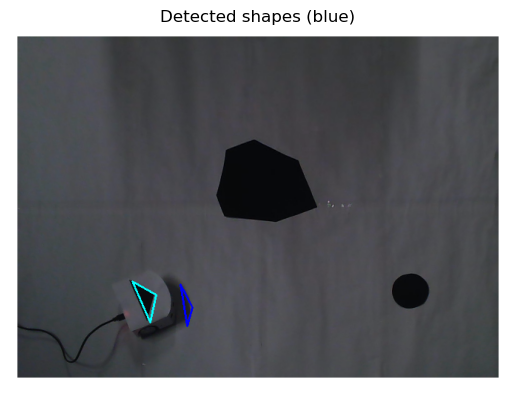

[[165 340]
 [189 395]
 [197 358]]
ROBOT FOUND
Trying to find obstacles
Trying to find obstacles
Trying to find obstacles
Trying to find obstacles
Trying to find obstacles
Trying to find obstacles
True
337.3339985885223
and true
Trying to find obstacles
Trying to find obstacles
True
157.79010168558492
and true
Trying to find obstacles
True
164.14735981586236
and true


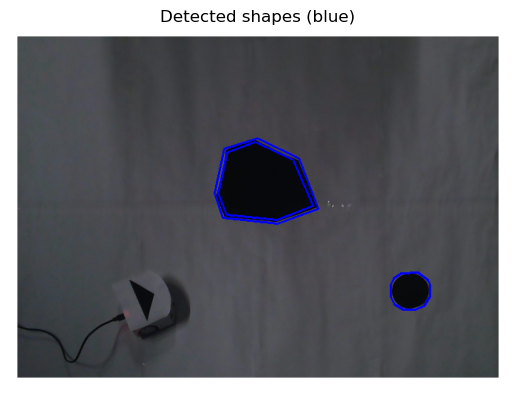

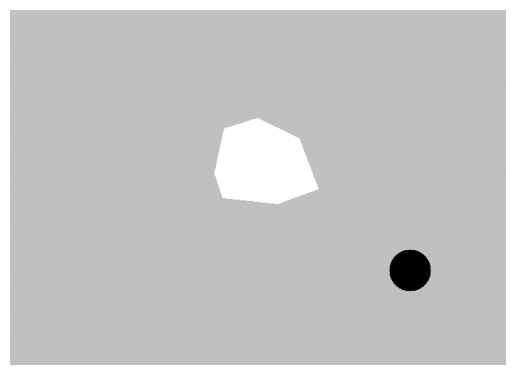

MAP ANALYZED : 
GOAL FOUND


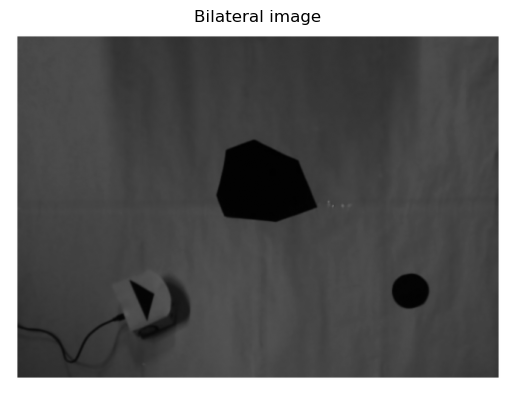

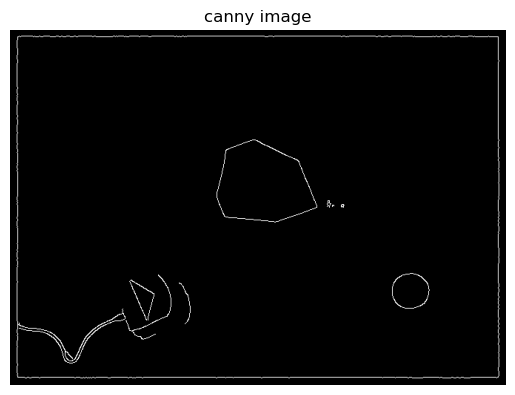

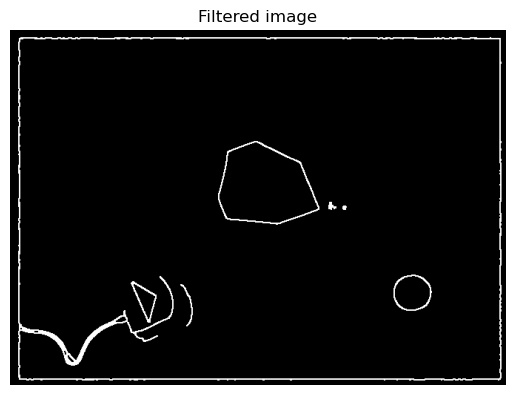

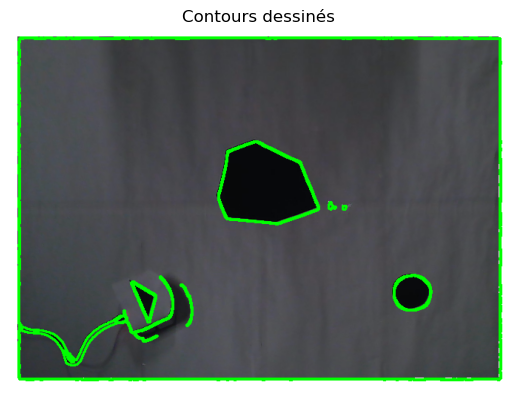

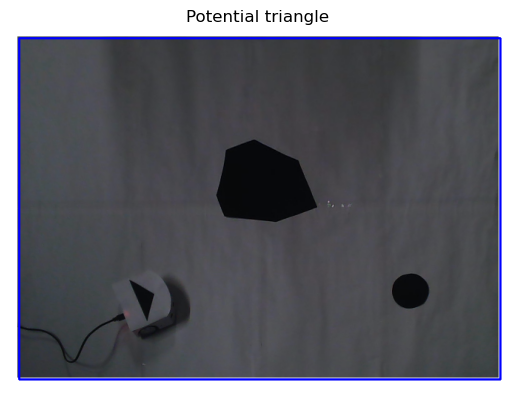

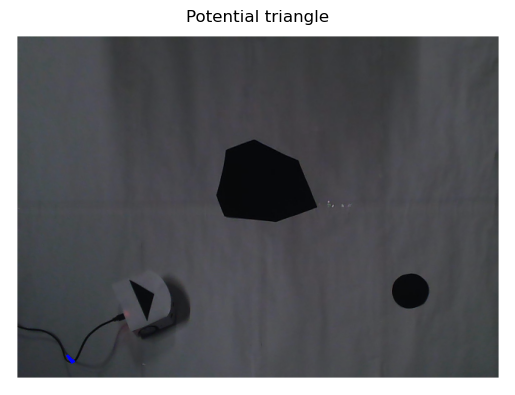

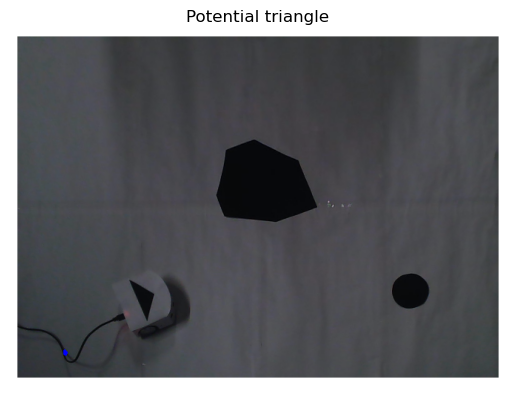

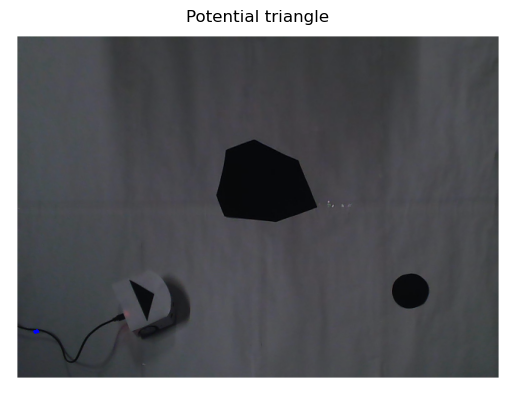

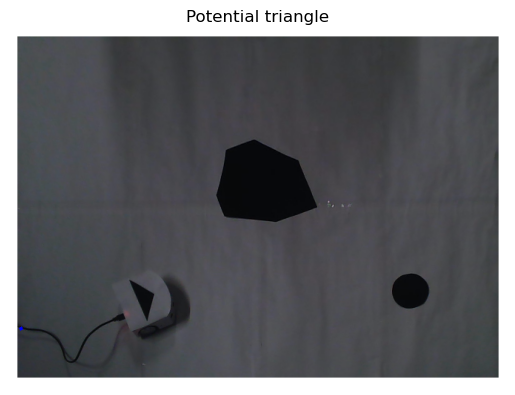

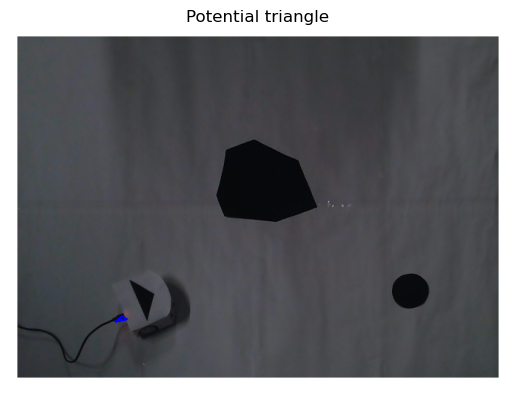

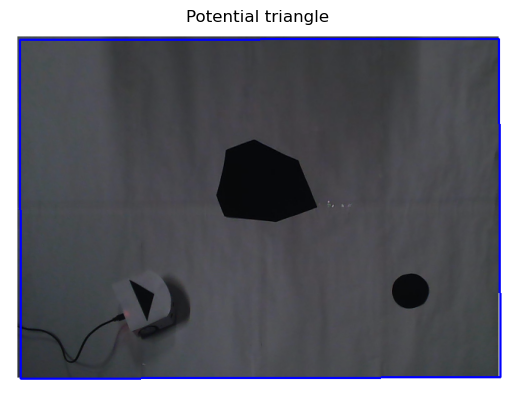

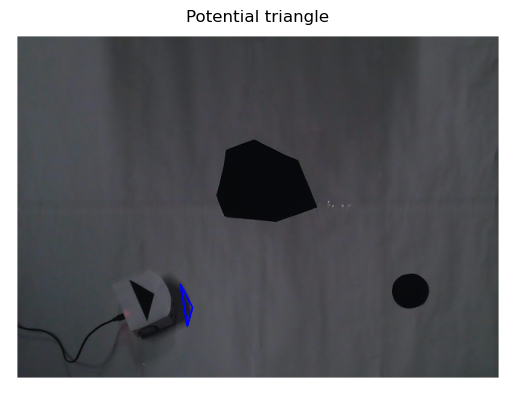

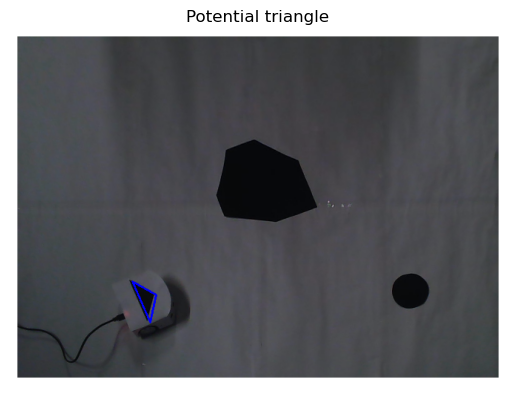

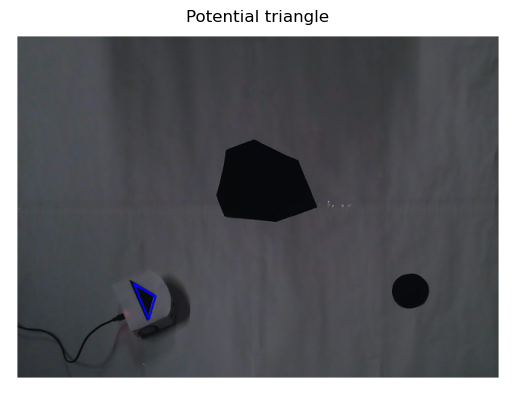

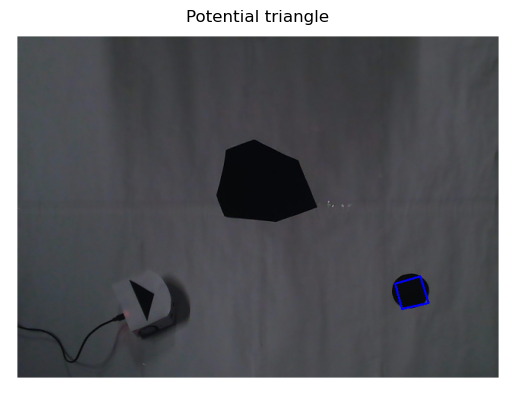

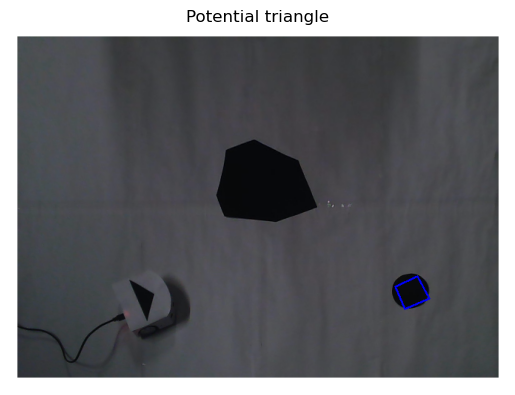

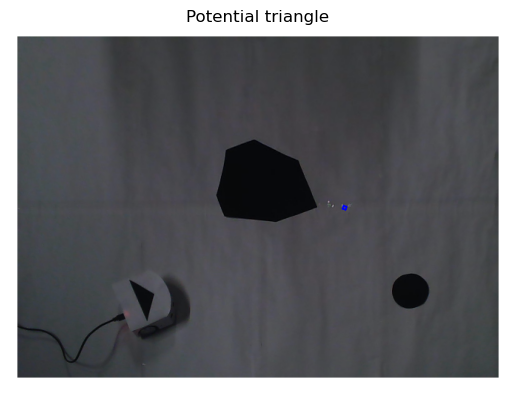

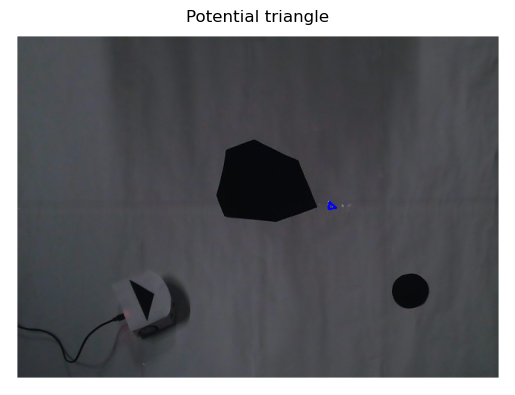

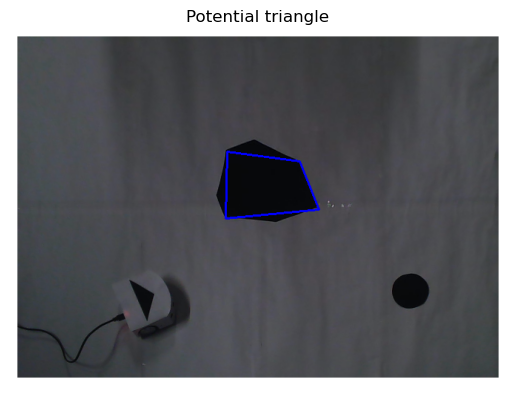

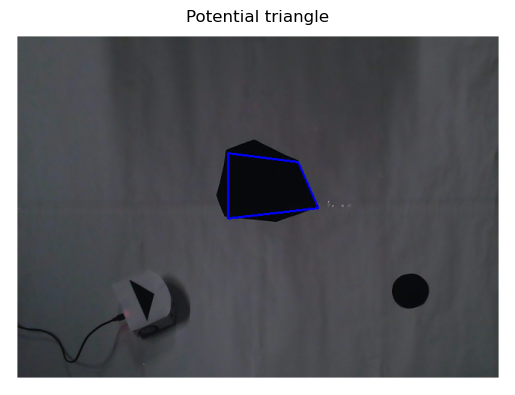

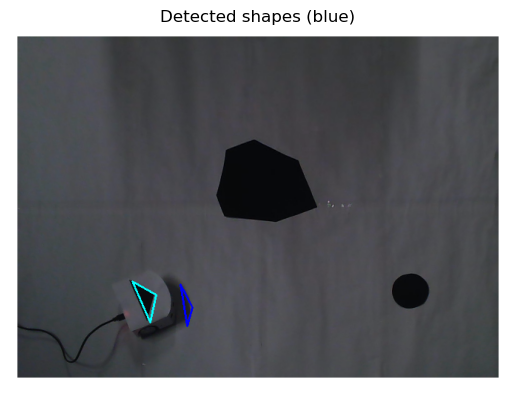

[[165 340]
 [189 395]
 [197 358]]
ROBOT FOUND
((np.float64(176.7167453485143), np.float64(366.8508747570119)), np.float64(-0.41145624341370163), True)


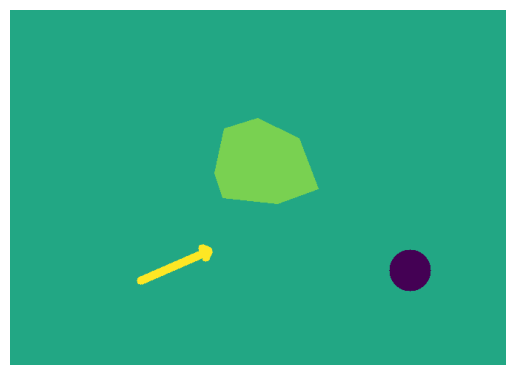

In [18]:
#ON WHAT PICTURE DO I WANT TO WORK

#EXTRACT PICTURE FROM THE CAMERA
img = get_picture_optimized(cap)

#LOAD A PICTURE FROM THE REPOSITORY
#img = cv2.imread("IMAGE_TEST11.png")
if img is None:
    raise ValueError("ERREUR : impossible de charger IMAGE_TEST1.jpg")

#COMPUTE THE TRANSFORMATION TO CORRECT PERSPECTIVE
matrix = matrix_perspective(img)

#CORRECT THE PERSPECTIVE
transformed_image = convert_perspective(img,matrix)

#PLOTTING
plt.figure()
plt.imshow(cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB))
plt.title("Perspective Corrected Image")
plt.axis('off')
plt.show()

#TO GET THE OCCUPANCY MAP + GOAL:
global_map = get_map(transformed_image)

#TO GET ROBOT POSITION
robot = get_robot(transformed_image)
print(robot)

#PLOTTING
global_map4plot = global_map.copy()
if robot[2] :
    length = 100
    end_x = int(robot[0][0] + length * np.cos(robot[1]))
    end_y = int(robot[0][1] + length * np.sin(robot[1]))
    end_point = (end_x, end_y)
    
    robot1 = [int(robot[0][0]),int(robot[0][1])]
    cv2.arrowedLine(global_map4plot, robot1, end_point, color=(2, 2, 2), thickness=10)


plt.imshow(global_map4plot)
plt.axis('off')
plt.show()